In [32]:
# Benchmark small CNN
import os
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import glob  # concise for finding files

# --- Configuration ---
SIZE = 500
BATCH_SIZE = 32
CHANNELS = 1
INPUT_SHAPE = (SIZE, SIZE, CHANNELS)


In [33]:

# --- Helper Functions ---

def load_labels(csv_path):
    df = pd.read_csv(csv_path, index_col='id')
    # skip 'male' column

    return df[['boneage']]


def create_dataframe(image_dir, labels_df):
    data = []
    # Use glob for potentially simpler file finding if needed, but os.listdir is fine
    # for filename in glob.glob(os.path.join(image_dir, '*.png')): # Example with glob
    for filename in os.listdir(image_dir):
        file_id = int(filename.split('.')[0])
        if file_id in labels_df.index:
            boneage = labels_df.loc[file_id, 'boneage']
            full_path = os.path.join(image_dir, filename)
            data.append({'file_path': full_path, 'boneage': boneage})
    return pd.DataFrame(data)


def preprocess_image(image, label):
    image = tf.image.resize(image, [SIZE, SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label  # labels are already structured


def image_label_generator(file_paths, boneage_labels):
    for path, boneage in zip(file_paths, boneage_labels):
        img_bytes = tf.io.read_file(path)
        # Ensure decoding works even if image isn't strictly PNG format but decodable
        image = tf.io.decode_image(img_bytes, channels=CHANNELS, expand_animations=False)
        # Set shape explicitly if decode_image doesn't infer it fully, needed by resize
        image.set_shape([None, None, CHANNELS])
        yield image, boneage  # Yield only boneage


def create_tf_dataset(dataframe, shuffle, repeat_flag, batch_size_local=BATCH_SIZE):
    dataset = tf.data.Dataset.from_generator(
        image_label_generator,
        args=[dataframe['file_path'].values, dataframe['boneage'].values],
        output_signature=(
            # Explicitly allow None for height/width before resizing
            tf.TensorSpec(shape=(None, None, CHANNELS), dtype=tf.uint8),
            tf.TensorSpec(shape=(), dtype=tf.float32)))

    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        # Use the length of the dataframe for buffer size for effective shuffling
        dataset = dataset.shuffle(buffer_size=len(dataframe), reshuffle_each_iteration=True)

    if repeat_flag:
        dataset = dataset.repeat()

    dataset = dataset.batch(batch_size_local)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [34]:

# --- Main Data Loading and Preprocessing ---

# Correct the paths if they are relative to a specific working directory
# Assuming the script runs from a directory containing Train/, Val/, Test/
train_csv_path = os.path.join('Train', 'train_labels.csv')
val_csv_path = os.path.join('Val', 'val_labels.csv')
test_csv_path = os.path.join('Test', 'test_labels.csv')

train_image_dir = os.path.join('Train', 'train_samples_pp')
val_image_dir = os.path.join('Val', 'val_samples_pp')
test_image_dir = os.path.join('Test', 'test_samples_pp')

#Load Labels
train_labels_df = load_labels(train_csv_path)
val_labels_df = load_labels(val_csv_path)
test_labels_df = load_labels(test_csv_path)

# DataFrames linking images and labels
training_dataframe = create_dataframe(train_image_dir, train_labels_df)
validation_dataframe = create_dataframe(val_image_dir, val_labels_df)
test_dataframe = create_dataframe(test_image_dir, test_labels_df)

# tf datasets
train_dataset = create_tf_dataset(training_dataframe, shuffle=True, repeat_flag=True)
validation_dataset = create_tf_dataset(validation_dataframe, shuffle=False, repeat_flag=True)
test_dataset_eval = create_tf_dataset(test_dataframe, shuffle=False, repeat_flag=False)


In [35]:
#test
for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Label batch example values:", label_batch.numpy()[:5])  # Print first 5 labels

Image batch shape: (32, 320, 320, 1)
Label batch shape: (32,)
Label batch example values: [ 48.  72. 126. 108. 150.]


In [36]:
steps_per_epoch = max(1, len(training_dataframe) // BATCH_SIZE)
validation_steps = max(1, len(validation_dataframe) // BATCH_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # output
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss='mse',
              metrics=['mae']) # mae for age prediction

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 318, 318, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 159, 159, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 157, 157, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 78, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 194688)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │    12,460,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,464,961 (47.55 MB)

 Trainable params: 12,464,961 (47.55 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Only train if datasets and steps are valid
history = model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps)

Epoch 1/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 109s 244ms/step - loss: 2826.8269 - mae: 41.3847 - val_loss: 1600.5068 - val_mae: 32.1901
Epoch 2/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - loss: 1504.9846 - mae: 31.4894 - val_loss: 1491.8259 - val_mae: 30.8815
Epoch 3/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 91s 243ms/step - loss: 1338.1129 - mae: 29.5155 - val_loss: 1385.1753 - val_mae: 30.0816
Epoch 4/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 92s 244ms/step - loss: 1258.8353 - mae: 28.6255 - val_loss: 1503.7275 - val_mae: 30.6475
Epoch 5/5
376/376 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - loss: 1202.1912 - mae: 27.9186 - val_loss: 1372.7382 - val_mae: 29.9761


In [38]:
test_loss, test_mae = model.evaluate(test_dataset_eval, verbose=1)
print(f'Test MAE: {test_mae:.2f} months')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 2278.0808 - mae: 40.5575
Test MAE: 37.98 months


C:\Users\alepa\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


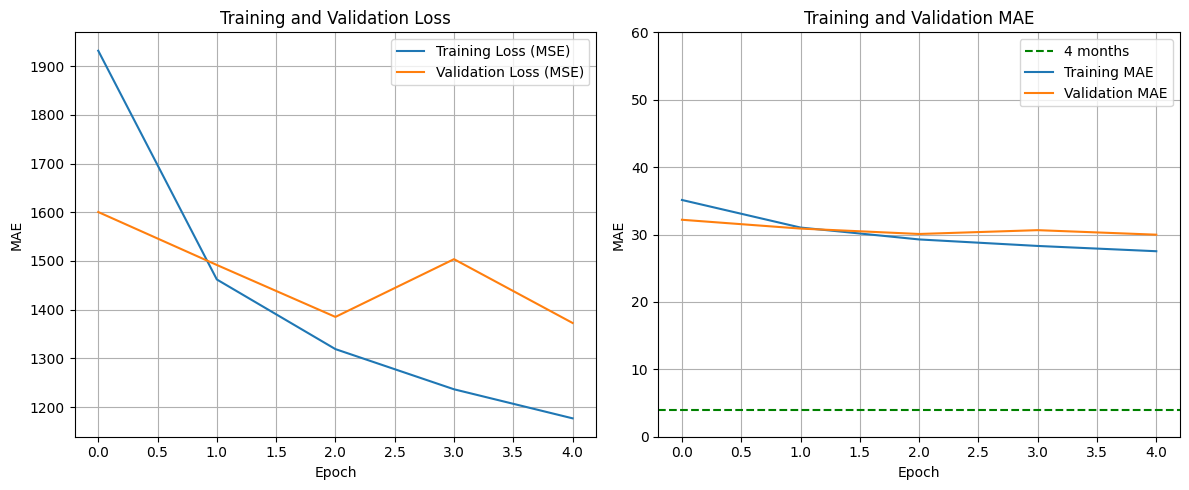

In [39]:
# Only plot if training occurred
plt.figure(figsize=(12, 5))  # Create a figure for the subplots

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.ylim(0, 60)
plt.axhline(y=4, color='g', linestyle='--', label='4 months')
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
